# Master Data Science Final Project - Start Ubi - Business Location Algorithm

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from shapely import wkt
import folium
import re
import requests
from sklearn import preprocessing

from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import transform
from functools import partial
import pyproj

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

# Web Scrapping

We use different types of tools and techniques to get the data.

Postman, Google Developer Tool, python.

For example, in order to scrape thefork, we generated with the browser a cookie and other headers (similar to what a human would generate). This helped us to bypass the captcha on the page. Then we generated a python script (with sleep time) to simulate being a human being and thus be able to download all the information from Barcelona.

In fotocasa, we search with GDT the hidden api and try to force get and post request to be able to receive the data in Json format and then reconvert them.

And other methods to be able to generate the different databases.


In [ ]:
#Scrapeando la pag de https://ajuntament.barcelona.cat/
# url = 'https://ajuntament.barcelona.cat/estadistica/angles/Estadistiques_per_temes/Habitatge_i_mercat_immobiliari/Mercat_immobiliari/Preu_oferta_habitatge_segona_ma/evo/t2mab.htm'
# response = requests.get(url)

# soup = BeautifulSoup(response.text, 'html.parser')
# table = soup.find('table')

# rows = table.find_all('tr')
# data = [[col.text.strip() for col in row.find_all('td')] for row in rows[1:]]
# data = data[3:]

# with open("precio_por_m2.csv", "w",encoding="utf-8") as f:
#     writer = csv.writer(f)
#     writer.writerows(data)

# Loading Datasets

In [ ]:
#Load Density
df_densidad= pd.read_csv('./2021_densitat.csv')

#Load district coordinates
df_distrito = gpd.read_file("districtes.geojson")

#Load neighborhoods coordinates
df_barrios = gpd.read_file("./barrios/barrios.json")

#Load availables restaurants
with open('./locales_disponibles_fotocasa/locales.json', encoding='utf-8') as fh:
    locales = json.load(fh)

#Load Markets
mercados = pd.read_csv('mercado.csv', sep=',')

#Load price per m2 built in BCN
df_metros_cuadrados= pd.read_csv('./precio_por_m2.csv')

#Load the Fork db
df_thefork=pd.read_csv('./thefork1.csv')

# Preprocesing


## Functions

In [ ]:
def minmax_norm(column):
    return (column - column.min()) / ( column.max() - column.min())

In [ ]:
def borrar_fuera(df):
    total_bounds=[41.3657,  2.1106, 41.4439,  2.2176]
    df = df.drop(df[(df.Latitud < 41.3657) | (df.Latitud > 41.4439) | (df.Longitud < 2.1106) | (df.Longitud > 2.2176) ].index)
    return df

In [ ]:
def cambiar_sistema_coor(geometry):

    crs_in = pyproj.CRS.from_epsg(25831)
    crs_out = pyproj.CRS.from_epsg(4326)
    project = partial(pyproj.transform, crs_in, crs_out)

    if isinstance(geometry, Polygon):
        transformed_polygon = transform(project, geometry)
        transformed_coords = [(abs(x[1]), abs(x[0])) for x in transformed_polygon.exterior.coords]
        return Polygon(transformed_coords)
    elif isinstance(geometry, MultiPolygon):
        polygons = []
        for poly in geometry:
            transformed_polygon = transform(project, poly)
            transformed_coords = [(abs(x[1]), abs(x[0])) for x in transformed_polygon.exterior.coords]
            polygons.append(Polygon(transformed_coords))
        return MultiPolygon(polygons)
    else:
        return geometry

In [ ]:
def cleaning(lista):
    dto = []
    barrios = []
    barrios_name = []

    for text in lista:
        # Use regex to extract the information
        match = re.search(r"(\d+)[\s\xa0]+(\d+)\.", text)
        if match:
            dto.append(int(match.group(1)))
            barrios.append(int(match.group(2)))
            barrios_name.append(text.split(match.group(0))[-1].strip())
    return dto,barrios,barrios_name

## Neighborhoods and Districts

In [ ]:
df_barrios=df_barrios.loc[df_barrios.TIPUS_UA=='BARRI'][['CODI_UA','NOM','geometry']].rename(columns={
                    'CODI_UA':'ID_barrio',
                    'NOM':'Nombre_barrio'}).reset_index(drop=True)
df_barrios['ID_barrio']=df_barrios.ID_barrio.astype(int)
df_barrios['geometry']=df_barrios['geometry'].apply(cambiar_sistema_coor)
df_barrios

ID_barrio                                 Nombre_barrio  \
0           1                                      el Raval   
1           2                                el Barri Gòtic   
2           3                                la Barceloneta   
3           4         Sant Pere, Santa Caterina i la Ribera   
4           5                                 el Fort Pienc   
..        ...                                           ...   
68         69  Diagonal Mar i el Front Marítim del Poblenou   
69         70                         el Besòs i el Maresme   
70         71                       Provençals del Poblenou   
71         72                      Sant Martí de Provençals   
72         73                           la Verneda i la Pau   

                                             geometry  
0   POLYGON ((2.16471 41.38593, 2.16401 41.38540, ...  
1   POLYGON ((2.17701 41.38525, 2.17658 41.38558, ...  
2   POLYGON ((2.19623 41.38745, 2.19617 41.38746, ...  
3   POLYGON ((2.18345 41.39061, 2.18238 41.39142, ...  
4   POLYGON ((2.18353 41.39227, 2.18388 41.39253, ...  
..                                                ...  
68  POLYGON ((2.21303 41.41093, 2.21190 41.41180, ...  
69  POLYGON ((2.21128 41.42167, 2.21056 41.42113, ...  
70  POLYGON ((2.19552 41.40560, 2.19552 41.40560, ...  
71  POLYGON ((2.19715 41.41109, 2.19751 41.41136, ...  
72  POLYGON ((2.20736 41.42711, 2.20684 41.42736, ...  

[73 rows x 3 columns]

In [ ]:
df_distrito = df_distrito[['NOM','geometry']].rename(
                        columns={
                                'NOM':'Nombre_districto'
                                })
df_distrito

Nombre_districto                                           geometry
0         Ciutat Vella  POLYGON ((2.18345 41.39061, 2.18459 41.38976, ...
1             Eixample  POLYGON ((2.18690 41.40165, 2.18689 41.40087, ...
2       Sants-Montjuïc  MULTIPOLYGON (((2.14824 41.37623, 2.14896 41.3...
3            Les Corts  POLYGON ((2.10342 41.40110, 2.10352 41.40109, ...
4  Sarrià-Sant Gervasi  MULTIPOLYGON (((2.07313 41.43522, 2.07319 41.4...
5               Gràcia  POLYGON ((2.13629 41.42363, 2.13640 41.42358, ...
6       Horta-Guinardó  POLYGON ((2.15949 41.44977, 2.15942 41.44960, ...
7           Nou Barris  POLYGON ((2.18706 41.46772, 2.18711 41.46711, ...
8          Sant Andreu  POLYGON ((2.18764 41.46212, 2.18765 41.46208, ...
9           Sant Martí  POLYGON ((2.20736 41.42711, 2.20698 41.42665, ...

## Population Density


<AxesSubplot:>

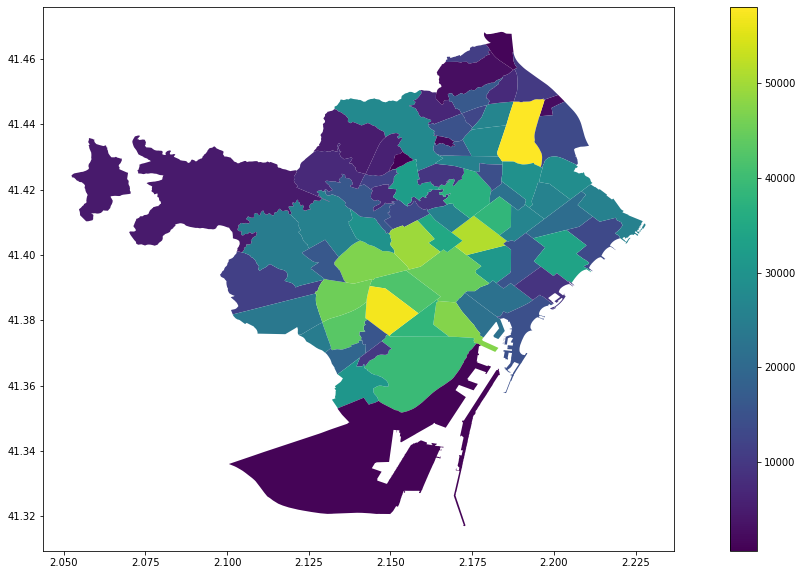

In [ ]:
df_densidad = df_densidad[['Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri','Població','Superfície Residencial (ha)','Densitat neta (hab/ha)']].rename(
                        columns={
                                'Codi_Districte': 'ID_districto',
                                'Nom_Districte': 'Nombre_districto',
                                'Codi_Barri': 'ID_barrio',
                                'Nom_Barri': 'Nombre_barrio',
                                'Població': 'Poblacion',
                                'Superfície Residencial (ha)': 'Superficie_residencial',
                                'Densitat neta (hab/ha)': 'Densidad_residencial_neta'
                                }).groupby(['ID_districto','Nombre_districto','Nombre_barrio', 'ID_barrio']).agg(Poblacion=('Poblacion','mean')).reset_index()


df_densidad_barrios = pd.merge(df_densidad, df_barrios, left_on='ID_barrio', right_on='ID_barrio')
gdf = gpd.GeoDataFrame(df_densidad_barrios)
gdf.plot(column='Poblacion', legend=True,figsize=(20,10))
# df_densidad_barrios['Poblacion']=minmax_norm(df_densidad_barrios['Poblacion'])

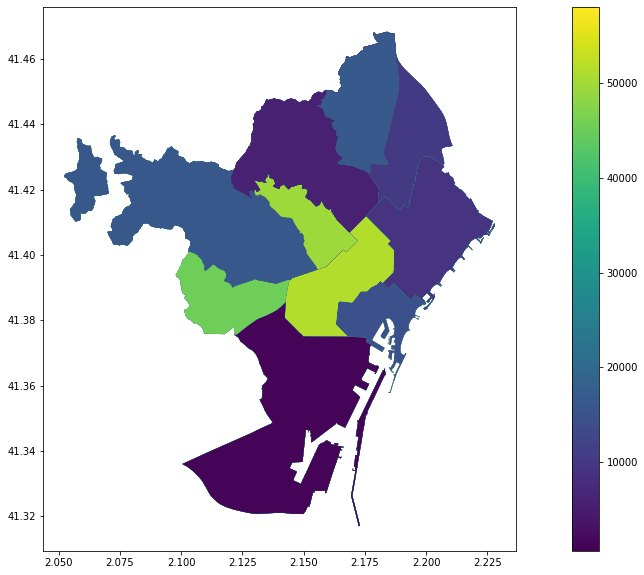

In [ ]:
df_densidad_distrito = pd.merge(df_densidad, df_distrito, left_on='Nombre_districto', right_on='Nombre_districto')
gdf = gpd.GeoDataFrame(df_densidad_distrito)
gdf.plot(column='Poblacion', legend=True,figsize=(20,10))
df_densidad_distrito['Poblacion']=minmax_norm(df_densidad_distrito['Poblacion'])

## Price per m2 built in BCN


In [ ]:
# Drop all the values before 2022
df_metros_cuadrados=df_metros_cuadrados.iloc[4:77,[0,-2]]

# Clean columns and standarizing of names
df_metros_cuadrados['ID_districto'],df_metros_cuadrados['ID_barrio'],df_metros_cuadrados['Nombre_barrio'] = cleaning(list(df_metros_cuadrados.iloc[:,0]))
df_metros_cuadrados=df_metros_cuadrados.iloc[:,1:]
df_metros_cuadrados['2022']=df_metros_cuadrados.iloc[:,0].astype(str).str.replace('\D','').replace('',np.nan).astype(float)
df_metros_cuadrados.rename(columns={'2022':'Precio_MetrosCuadrados'},inplace=True)

#Filling null values
df_metros_cuadrados.fillna(value=df_metros_cuadrados['Precio_MetrosCuadrados'].mean(),inplace=True)

#Normalization
# df_metros_cuadrados['Precio_MetrosCuadrados']=minmax_norm(df_metros_cuadrados.Precio_MetrosCuadrados)

df_metros_cuadrados

Precio_MetrosCuadrados  ID_districto  ID_barrio  \
4                   3374.0             1          1   
5                   5186.0             1          2   
6                   4732.0             1          3   
7                   4705.0             1          4   
8                   4644.0             2          5   
..                     ...           ...        ...   
72                  7524.0            10         69   
73                  2184.0            10         70   
74                  3319.0            10         71   
75                  2975.0            10         72   
76                  2606.0            10         73   

                                   Nombre_barrio  
4                                       el Raval  
5                                 el Barri Gòtic  
6                                 la Barceloneta  
7          Sant Pere, Santa Caterina i la Ribera  
8                                  el Fort Pienc  
..                                           ...  
72  Diagonal Mar i el Front Marítim del Poblenou  
73                         el Besòs i el Maresme  
74                       Provençals del Poblenou  
75                      Sant Martí de Provençals  
76                           la Verneda i la Pau  

[73 rows x 4 columns]

## Existing restaurants


In [ ]:
df_thefork= df_thefork[['priceRange','name','servesCuisine','address.street','aggregateRatings.thefork.ratingValue','aggregateRatings.thefork.reviewCount','geo.latitude','geo.longitude']].dropna()
#Normalization
# df_thefork['priceRange'] = minmax_norm(df_thefork['priceRange'])
df_thefork['aggregateRatings.thefork.ratingValue'] = minmax_norm(df_thefork['aggregateRatings.thefork.ratingValue'])
df_thefork['aggregateRatings.thefork.reviewCount'] = minmax_norm(df_thefork['aggregateRatings.thefork.reviewCount'])

#Names standarization
df_thefork.rename(columns={'priceRange':'Precio_medio',
                           'name':'Nombre',
                           'servesCuisine':'Tipo_cocina',
                           'address.street':'Direccion',
                           'aggregateRatings.thefork.ratingValue':'Rating',
                           'aggregateRatings.thefork.reviewCount':'Cantidad_rating',
                           'geo.latitude':'Latitud',
                           'geo.longitude':'Longitud'},inplace=True)

df_thefork['geometry'] = df_thefork.apply(lambda row: wkt.loads(f'POINT({row["Longitud"]:.4f} {row["Latitud"]:.4f})'), axis=1)

df_thefork=borrar_fuera(df_thefork)

# <20 becomes other kitchen type

otros_m20= list(df_thefork.groupby(by='Tipo_cocina')
                .agg(cantidad=('Tipo_cocina','count'))
                .sort_values(by='cantidad',ascending=False)
                .reset_index()
                .loc[df_thefork.groupby(by='Tipo_cocina')
                                   .agg(cantidad=('Tipo_cocina','count'))
                                   .sort_values(by='cantidad',ascending=False)
                                   .reset_index()
                                   .cantidad<20,'Tipo_cocina'])
df_thefork.loc[(df_thefork.Tipo_cocina.isin(otros_m20)),'Tipo_cocina']='Otros'

In [ ]:
df_thefork[['Nombre_barrio','ID_barrio']]=None
for i,row in df_thefork.iterrows():
    for j, fila in df_barrios.iterrows():
        if fila.geometry.contains(row.geometry):
            df_thefork.loc[i,'Nombre_barrio']=fila.Nombre_barrio
            df_thefork.loc[i,'ID_barrio']=fila.ID_barrio

df_thefork

Precio_medio                                             Nombre  \
0             25.0                             Transilvania Barcelona   
1             30.0                                           Casa Xef   
2             40.0                                           Vi Negre   
3             49.0  Fonda España by Martín Berasategui - Hotel España   
4             50.0                                            La Tata   
...            ...                                                ...   
1194          18.0                                            Rústico   
1195          30.0                                              Louro   
1196          15.0                                          INKA BURG   
1197          57.0                                    Dry Martini Bar   
1199          20.0                                           Le Divan   

       Tipo_cocina                               Direccion  Rating  \
0            Otros                      C/ de Provença, 99    0.94   
1     Mediterráneo            Carrer de les Guilleries, 17    0.86   
2     Mediterráneo            Carrer de les Guilleries, 17    0.84   
3          Catalán                       C/ de Sant Pau, 9    0.92   
4     Mediterráneo                  Carrer de Calàbria, 69    0.94   
...            ...                                     ...     ...   
1194         Otros                     Carrer de Terol, 39    0.84   
1195         Otros               Rambla dels Caputxins, 37    0.90   
1196  Mediterráneo  Avinguda de la República Argentina, 17    0.84   
1197  Mediterráneo                    Carrer d'Aribau, 162    0.92   
1199     De Fusión              Carrer de Guillem Tell, 10    0.88   

      Cantidad_rating    Latitud  Longitud                geometry  \
0            0.038962  41.386386  2.149974    POINT (2.15 41.3864)   
1            0.014014  41.403299  2.156517  POINT (2.1565 41.4033)   
2            0.179836  41.403344  2.156571  POINT (2.1566 41.4033)   
3            0.091072  41.380753  2.173140  POINT (2.1731 41.3808)   
4            0.225436  41.378144  2.156884  POINT (2.1569 41.3781)   
...               ...        ...       ...                     ...   
1194         0.002084  41.403379  2.158512  POINT (2.1585 41.4034)   
1195         0.050603  41.379075  2.174604  POINT (2.1746 41.3791)   
1196         0.003239  41.407736  2.147834  POINT (2.1478 41.4077)   
1197         0.000064  41.392758  2.153916  POINT (2.1539 41.3928)   
1199         0.002662  41.403141  2.149283  POINT (2.1493 41.4031)   

                        Nombre_barrio ID_barrio  
0      la Nova Esquerra de l'Eixample         9  
1                   la Vila de Gràcia        31  
2                   la Vila de Gràcia        31  
3                            el Raval         1  
4                         Sant Antoni        10  
...                               ...       ...  
1194                la Vila de Gràcia        31  
1195                         el Raval         1  
1196             el Putxet i el Farró        27  
1197  l'Antiga Esquerra de l'Eixample         8  
1199             el Putxet i el Farró        27  

[1108 rows x 11 columns]

## Providers' markets

In [ ]:
mercados = mercados[['name','addresses_neighborhood_id','addresses_district_id','values_value', 'geo_epgs_4326_x', 'geo_epgs_4326_y']]
mercados = mercados.rename(columns={
                                'name': 'Nombre',
                                'addresses_neighborhood_id': 'ID_Barrio',
                                'addresses_district_id': 'ID_Districto',
                                'values_value': 'Telefono',
                                'geo_epgs_4326_x': 'Latitud',
                                'geo_epgs_4326_y': 'Longitud'})

mercados['geometry'] = mercados.apply(lambda row: wkt.loads(f'POINT({row["Longitud"]:.4f} {row["Latitud"]:.4f})'), axis=1)

# Limpiando duplicados
mercados = mercados.drop_duplicates(subset=['Latitud','Longitud','Telefono'], keep='last').reset_index(drop=True)
mercados = borrar_fuera(mercados)
mercados

Nombre  ID_Barrio  ID_Districto  \
0                            Mercat de Canyelles         49             8   
2                           Mercat de Sant Martí         73            10   
3                               Mercat del Besòs         70            10   
4                       Mercat de La Barceloneta          3             1   
5                               Mercat del Ninot          8             2   
6                         Mercat de la Llibertat         31             6   
7                              Mercat del Carmel         37             7   
8                               Mercat de Sarrià         23             5   
9                   Mercat de l'Abaceria Central         32             6   
10              Mercat de les Flors *Les Rambles          2             1   
12                            Mercat de Felip II         61             9   
14                         Mercat de Sant Andreu         60             9   
15            Mercat de Sant Josep - La Boqueria          1             1   
16                      Mercat de Santa Caterina          4             1   
17                          Mercat d'Hostafrancs         15             3   
18                               Mercat de Sants         18             3   
20             Mercat de Vall d'Hebron -Taxonera         38             7   
21                                Mercat d'Horta         43             7   
22                            Mercat de La Mercè         46             8   
23                         Mercat del Bon Pastor         59             9   
24                             Mercat de Lesseps         30             6   
25                 Mercat Encants de Sant Antoni         10             2   
26                     Mercat de Les Tres Torres         24             5   
27                        Mercat de Sant Gervasi         25             5   
28  Mercat Encants Barcelona - Fira de Bellcaire          5             2   
29                         Mercat del Fort Pienc          5             2   
30                               Mercat del Clot         65            10   
31                    Mercat del Poblenou - Unió         68            10   
32                          Mercat de Provençals         72            10   
33                           Mercat del Guinardó         35             7   
34                        Mercat de La Guineueta         48             8   
35                        Mercat de La Concepció          7             2   
36                  Mercat de la Sagrada Família          6             2   
37                         Mercat de Sant Antoni         10             2   
38                           Mercat de Les Corts         19             4   
39                             Mercat de Galvany         26             5   
41                          Mercat de l'Estrella         32             6   

     Telefono    Latitud  Longitud                geometry  
0   934132324  41.441988  2.164427   POINT (2.1644 41.442)  
2   934132297  41.418656  2.205323  POINT (2.2053 41.4187)  
3   934132305  41.419232  2.215129  POINT (2.2151 41.4192)  
4   934132304  41.380246  2.189281  POINT (2.1893 41.3802)  
5   934132322  41.387857  2.154412  POINT (2.1544 41.3879)  
6   933687946  41.399738  2.153748  POINT (2.1537 41.3997)  
7   934132335  41.423740  2.155810  POINT (2.1558 41.4237)  
8   934132326  41.399836  2.120723  POINT (2.1207 41.3998)  
9   934132313  41.403187  2.164179  POINT (2.1642 41.4032)  
10          -  41.382986  2.171948   POINT (2.1719 41.383)  
12  934132337  41.422026  2.185093   POINT (2.1851 41.422)  
14  934132342  41.434893  2.188393  POINT (2.1884 41.4349)  
15  934132303  41.382049  2.172271   POINT (2.1723 41.382)  
16  934132298  41.386395  2.178177  POINT (2.1782 41.3864)  
17  934132307  41.375162  2.143854  POINT (2.1439 41.3752)  
18  932694472  41.374741  2.133755  POINT (2.1338 41.3747)  
20  934132344  41.424062  2.142452  POINT (2.1425 41.4241)  
21  934204858  41

## Locals availables

In [ ]:
result_dict = {}
for i in range(len(locales['realEstates'])):
    tel= locales['realEstates'][i]['advertiser']['phone']
    precio=int(str(locales['realEstates'][i]['transactions'][0]['value'][0]))
    website = 'https://www.fotocasa.es' + locales['realEstates'][i]['detail']['es']
    lat = locales['realEstates'][i]['address']['coordinates']['latitude']
    long = locales['realEstates'][i]['address']['coordinates']['longitude']
    result_dict[i] = {'Website': website, 'Latitud': lat, 'Longitud': long, 'Precio':precio, 'Telefono':tel}
locales=pd.DataFrame(data=result_dict).T

#we cut the points to barcelona only with the parameters of restaurants.total_bounds
locales = borrar_fuera(locales)
locales = locales.drop_duplicates(subset=['Website','Latitud','Longitud','Precio','Telefono'], keep='last').reset_index(drop=True)
locales['geometry'] = locales.apply(lambda row: wkt.loads(f'POINT({row["Longitud"]:.4f} {row["Latitud"]:.4f})'), axis=1)


locales[['Nombre_barrio','ID_barrio']]=None
for i,row in locales.iterrows():
    for j, fila in df_barrios.iterrows():
        if fila.geometry.contains(row.geometry):
            locales.loc[i,'Nombre_barrio']=fila.Nombre_barrio
            locales.loc[i,'ID_barrio']=fila.ID_barrio

locales

Website  Latitud Longitud  \
0    https://www.fotocasa.es/es/alquiler/local-come...  41.3785  2.16071   
1    https://www.fotocasa.es/es/alquiler/local-come...   41.384  2.16148   
2    https://www.fotocasa.es/es/alquiler/local-come...  41.4259  2.18056   
3    https://www.fotocasa.es/es/alquiler/local-come...   41.384  2.18295   
4    https://www.fotocasa.es/es/alquiler/local-come...   41.412  2.19968   
..                                                 ...      ...      ...   
182  https://www.fotocasa.es/es/alquiler/local-come...   41.412  2.13851   
183  https://www.fotocasa.es/es/alquiler/local-come...  41.3774   2.1743   
184  https://www.fotocasa.es/es/alquiler/local-come...   41.404  2.19061   
185  https://www.fotocasa.es/es/alquiler/local-come...  41.3887  2.17824   
186  https://www.fotocasa.es/es/alquiler/local-come...  41.3795  2.13448   

    Precio   Telefono                geometry  \
0     7000  931341506  POINT (2.1607 41.3785)   
1     3400  931348196   POINT (2.1615 41.384)   
2      395  932886902  POINT (2.1806 41.4259)   
3     2500  972083512    POINT (2.183 41.384)   
4     2490  935432760   POINT (2.1997 41.412)   
..     ...        ...                     ...   
182   1100  930443912   POINT (2.1385 41.412)   
183    990  931332451  POINT (2.1743 41.3774)   
184   2500  931340598   POINT (2.1906 41.404)   
185    890  932757012  POINT (2.1782 41.3887)   
186    550  932938646  POINT (2.1345 41.3795)   

                             Nombre_barrio ID_barrio  
0                              Sant Antoni        10  
1                              Sant Antoni        10  
2                 el Congrés i els Indians        62  
3    Sant Pere, Santa Caterina i la Ribera         4  
4                  Provençals del Poblenou        71  
..                                     ...       ...  
182                   el Putxet i el Farró        27  
183                               el Raval         1  
184      el Parc i la Llacuna del Poblenou        66  
185  Sant Pere, Santa Caterina i la Ribera         4  
186                                  Sants        18  

[187 rows x 8 columns]

# Map visualization

In [ ]:
BARCA_COORDS = [df_thefork['Latitud'].mean(), df_thefork['Longitud'].mean()]

m = folium.Map(BARCA_COORDS, zoom_start=13)

for index, row in df_thefork.iterrows():
    if row['Latitud'] != np.nan and row['Longitud'] != np.nan:

        html = f'''
                    <b>Nombre: </b>{row['Nombre']}<br>
                    <b>Precio promedio: </b>{row['Precio_medio']}<br>
                    <b>Tipo de comida: </b>{row['Tipo_cocina']}<br>
                    <b>Direccion: </b>{row['Direccion']}<br>'''

        folium.Popup(html, parse_html=False, max_width=1000),
        folium.CircleMarker([row['Latitud'], row['Longitud']],
                            radius=2,
                            popup=(folium.Popup(html, parse_html=False, max_width=1000)),
                            fill_color="#3db7e4",
                            ).add_to(m)

for index, row in locales.iterrows():

    html = f'''
                    <b>Precio: </b>{row['Precio']}<br>
                    <b>Telefono: </b>{row['Telefono']}<br>
                    <b>Website: </b>{row['Website']}<br>'''

    folium.CircleMarker([row['Latitud'], row['Longitud']],
                            radius=3,
                            popup=(folium.Popup(html, parse_html=False, max_width=1000)),
                            color='red',
                            ).add_to(m)

for index, row in mercados.iterrows():

    html = f'''
                    <b>Nombre: </b>{row['Nombre']}<br>
                    <b>Telefono: </b>{row['Telefono']}<br>'''
    folium.CircleMarker([row['Latitud'], row['Longitud']],
                            radius=3,
                            popup=(folium.Popup(html, parse_html=False, max_width=1000)),
                            color='#39ff14',
                            ).add_to(m)

m

# Datasets' Merge

## Feature engineering

In [ ]:
## thefork, densidad, precio_m2, mercados

df_densidad_metro = pd.merge(df_densidad_barrios, df_metros_cuadrados, left_on='ID_barrio', right_on='ID_barrio')
final = pd.merge(df_thefork, df_densidad_metro, left_on='ID_barrio', right_on='ID_barrio')

final['Factor']= (((final.Precio_medio*final.Precio_MetrosCuadrados)+ \
                 (final.Poblacion/final.Precio_MetrosCuadrados))/10000 +\
                 (final.Rating*final.Cantidad_rating*10))

final['Factor']=minmax_norm(final['Factor'])
X=final[['Tipo_cocina','Factor']]
Y=final[['Latitud','Longitud']]

<AxesSubplot:>

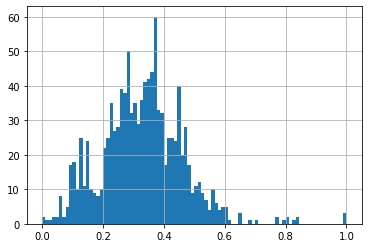

In [ ]:
# Posible Factor
minmax_norm(minmax_norm(final.Precio_medio)*1+minmax_norm(final.Precio_MetrosCuadrados)*1.+ \
 minmax_norm(final.Poblacion)*0.+minmax_norm(final.Rating*final.Cantidad_rating)*1.).hist(bins=90)

<AxesSubplot:>

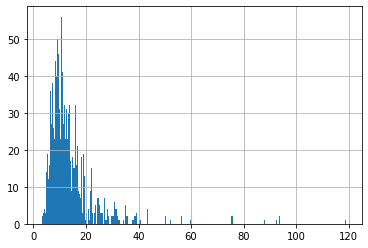

In [ ]:
(((final.Precio_medio*final.Precio_MetrosCuadrados)+ \
(final.Poblacion/final.Precio_MetrosCuadrados))/10000 +\
(final.Rating*final.Cantidad_rating*10)).hist(bins=300)

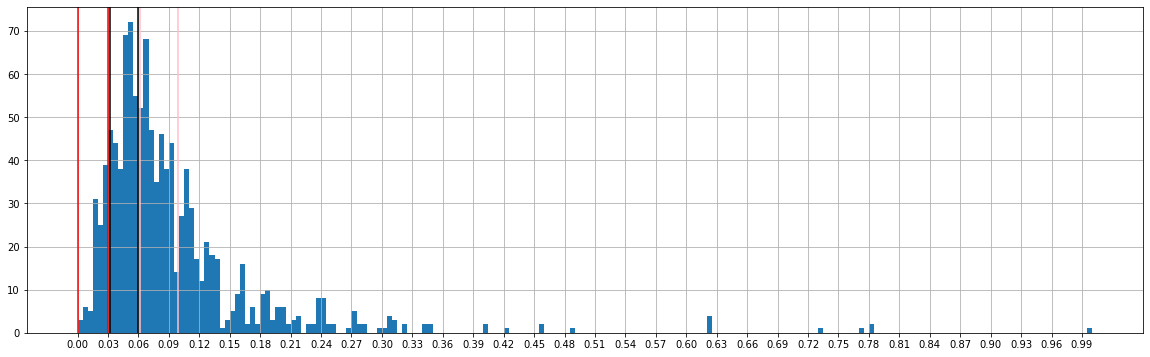

In [ ]:
final.Factor.hist(bins=200,figsize=(20,6),width=.005)
plt.axvline(x=0.00,color='red')
plt.axvline(x=0.03,color='red')
plt.axvline(x=0.032,color='black')
plt.axvline(x=.06,color='black')
plt.axvline(x=.062,color='pink')
plt.axvline(x=.099,color='pink')
# plt.axvline(x=.1,color='pink')
plt.xticks(np.arange(0, 1, step=0.03))
plt.show()


### Customer type sectoring 
- 0 - 0.03   Cheap
- 0.03 - .06  Middle
- .06 - .099  Expensive
- .099 - 1    Very Expensive

In [ ]:
X.loc[((X.Factor>0.03) & (X.Factor<=0.06)),'cliente_1'] = 1
X.loc[((X.Factor>0.06) & (X.Factor<=0.099)),'cliente_2'] = 1
X.loc[X.Factor>0.099,'cliente_3'] = 1
X=X.fillna(0)
X= pd.get_dummies(data = X, columns=['Tipo_cocina'],drop_first=True)
X=X.drop(columns="Factor")
X=X.astype(int)

We define 4 types of clients considering what is generated as the Factor column.
It would be the first 3 switches.

| ClientType | Bit1 | Bit2 | Bit3 |
| :- | :-: | :-: | :-: |
|customer0, cheap places.   |0|0|0|
|customer1, midlle places.    |1|0|0|
|customer2, expensive places.     |0|1|0|
|customer3, very expensive places. |0|0|1|

As for the kitchen, we will generate 14 groups.

| Cuisine type | Bit1 | Bit2 | Bit3 | Bit4 | Bit5 | Bit6 | Bit7 | Bit8 | Bit9 |Bit10 | Bit11 | Bit12 | Bit13 |
| :- | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|0-American        |0|0|0|0|0|0|0|0|0|0|0|0|0|
|1-Rise        |1|0|0|0|0|0|0|0|0|0|0|0|0|
|2-Asian         |0|1|0|0|0|0|0|0|0|0|0|0|0|
|3-Catalan          |0|0|1|0|0|0|0|0|0|0|0|0|0|
|4-Fusion       |0|0|0|1|0|0|0|0|0|0|0|0|0|
|5-Spain         |0|0|0|0|1|0|0|0|0|0|0|0|0|
|6-Indian            |0|0|0|0|0|1|0|0|0|0|0|0|0|
|7-International    |0|0|0|0|0|0|1|0|0|0|0|0|0|
|8-Italian        |0|0|0|0|0|0|0|1|0|0|0|0|0|
|9-Japanese       |0|0|0|0|0|0|0|0|1|0|0|0|0|
|10-Mediteranean    |0|0|0|0|0|0|0|0|0|1|0|0|0|
|11-Mexican        |0|0|0|0|0|0|0|0|0|0|1|0|0|
|12-Others           |0|0|0|0|0|0|0|0|0|0|0|1|0|
|13-Peruan         |0|0|0|0|0|0|0|0|0|0|0|0|1|


In [ ]:
list(X.loc[0])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

### Function to generate array

In [ ]:
cli_cocina(3,13)


[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

In [ ]:
def cli_cocina(num_cli,num_rest):
    '''
    num_rest
    0-American		7-International
    1-Rise		    8-Italian
    2-Asian		    9-Japanese
    3-Catalan		10-Mediterranean
    4-Fusion		11-Mexican
    5-Spain		    12-Others
    6-Indian		13-Peruan
    num_cli
    0-Customer 0		2-Customer 2
    1-Customer 1		3-Customer 3
    '''

    valid_cli = [0, 1, 2, 3]
    if num_cli not in valid_cli:
        print("Invalid input. Please enter a number between 0 and 3 for the customer type.")
        return None
    else:
        cli_ind = int(num_cli)
        list_cli = [0] * 3
        if cli_ind > 0 and cli_ind <= 3:
            list_cli[cli_ind-1] = 1


    valid_rest = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    if num_rest not in valid_rest:
        print("Invalid input. Please enter a number between 0 and 13 for restaurant inputs.")
        return None
    else:
        rest_ind = int(num_rest)
        list_rest = [0] * 13
        if rest_ind > 0 and rest_ind <= 13:
            list_rest[rest_ind-1] = 1

    return [list_cli + list_rest]

# Training

## K Neighbors using full dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X, Y)

new_restaurant = np.array(cli_cocina(1,1)) # cli 0 - Americano


predicted_coordinates = model.predict(new_restaurant)

available_places = [(x[0],x[1]) for i,x in locales[['Latitud','Longitud']].iterrows()]

distances = [distance.euclidean(predicted_coordinates[0], place) for place in available_places]

closest_places_indices = np.argsort(distances)[:3]

closest_places = [available_places[index] for index in closest_places_indices]

print("The 3 closest available places to the predicted coordinates are:")
for i, place in enumerate(closest_places):
    print(f"{i+1}. ({place[0]:.4f}, {place[1]:.4f})")

The 3 closest available places to the predicted coordinates are:
1. (41.4010, 2.1640)
2. (41.4010, 2.1628)
3. (41.4032, 2.1648)


In [ ]:
BARCA_COORDS = [df_thefork['Latitud'].mean(), df_thefork['Longitud'].mean()]

m = folium.Map(BARCA_COORDS, zoom_start=13)

for index, row in df_thefork.iterrows():
    if row['Latitud'] != np.nan and row['Longitud'] != np.nan:

        html = f'''
                    <b>Nombre: </b>{row['Nombre']}<br>
                    <b>Precio promedio: </b>{row['Precio_medio']}<br>
                    <b>Tipo de comida: </b>{row['Tipo_cocina']}<br>
                    <b>Direccion: </b>{row['Direccion']}<br>'''

        folium.Popup(html, parse_html=False, max_width=1000),
        folium.CircleMarker([row['Latitud'], row['Longitud']],
                            radius=2,
                            popup=(folium.Popup(html, parse_html=False, max_width=1000)),
                            fill_color="#3db7e4",
                            ).add_to(m)

for index, row in mercados.iterrows():

    html = f'''
                    <b>Nombre: </b>{row['Nombre']}<br>
                    <b>Telefono: </b>{row['Telefono']}<br>'''
    folium.CircleMarker([row['Latitud'], row['Longitud']],
                            radius=3,
                            popup=(folium.Popup(html, parse_html=False, max_width=1000)),
                            color='#39ff14',
                            ).add_to(m)


for index, row in locales.iterrows():

    html = f'''
                    <b>Precio: </b>{row['Precio']}<br>
                    <b>Telefono: </b>{row['Telefono']}<br>
                    <b>Website: </b>{row['Website']}<br>'''

    folium.CircleMarker([row['Latitud'], row['Longitud']],
                            radius=3,
                            popup=(folium.Popup(html, parse_html=False, max_width=1000)),
                            color='red',
                            ).add_to(m)

for index, row in enumerate(closest_places):
    folium.CircleMarker([row[0], row[1]],
                            radius=6,
                            color='black',
                            ).add_to(m)

folium.CircleMarker([predicted_coordinates.tolist()[0][0], predicted_coordinates.tolist()[0][1]],
                            radius=5,
                            popup=f'PREDICHO',
                            fill_opacity=1.0,
                            fill_color='black',
                            color='#cf2d71',
                            ).add_to(m)
m

## Training many models at the same time

In [ ]:
# Train and evaluate models
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
models = [
    KNeighborsRegressor(),
    MultiOutputRegressor(SVR()),
#     MLPRegressor(random_state=42)
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
    MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
]
cheto=[]
for model in models:
    model.fit(X_train, y_train)
    cheto.append(model.fit(X_train, y_train))
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Model: {type(model).__name__}, MSE: {mse:.2f}")

Model: KNeighborsRegressor, MSE: 0.00
Model: MultiOutputRegressor, MSE: 0.00
Model: LinearRegression, MSE: 0.00
Model: DecisionTreeRegressor, MSE: 0.00
Model: MultiOutputRegressor, MSE: 0.00


# Testing

In [ ]:
X_test=cli_cocina(0,6) 
puntos = [x.predict(X_test).tolist() for x in cheto]

In [ ]:
available_places = [(x[0],x[1]) for i,x in locales[['Latitud','Longitud']].iterrows()]

for i,punto in enumerate(puntos):
    distances = [distance.euclidean(punto[0], place) for place in available_places]
    closest_places_indices = np.argsort(distances)[:3]
    closest_places = [available_places[index] for index in closest_places_indices]
    puntos[i].append(closest_places)

In [ ]:
BARCA_COORDS = [df_thefork['Latitud'].mean(), df_thefork['Longitud'].mean()]

m = folium.Map(BARCA_COORDS, zoom_start=13)

for index, row in df_thefork.iterrows():
    if row['Latitud'] != np.nan and row['Longitud'] != np.nan:

        html = f'''
                    <b>Nombre: </b>{row['Nombre']}<br>
                    <b>Precio promedio: </b>{row['Precio_medio']}<br>
                    <b>Tipo de comida: </b>{row['Tipo_cocina']}<br>
                    <b>Direccion: </b>{row['Direccion']}<br>'''

        folium.Popup(html, parse_html=False, max_width=1000),
        folium.CircleMarker([row['Latitud'], row['Longitud']],
                            radius=2,
                            popup=(folium.Popup(html, parse_html=False, max_width=1000)),
                            fill_color="#3db7e4",
                            ).add_to(m)

for index, row in mercados.iterrows():

    html = f'''
                    <b>Nombre: </b>{row['Nombre']}<br>
                    <b>Telefono: </b>{row['Telefono']}<br>'''
    folium.CircleMarker([row['Latitud'], row['Longitud']],
                            radius=3,
                            popup=(folium.Popup(html, parse_html=False, max_width=1000)),
                            color='#39ff14',
                            ).add_to(m)


for index, row in locales.iterrows():

    html = f'''
                    <b>Precio: </b>{row['Precio']}<br>
                    <b>Telefono: </b>{row['Telefono']}<br>
                    <b>Website: </b>{row['Website']}<br>'''

    folium.CircleMarker([row['Latitud'], row['Longitud']],
                            radius=3,
                            popup=(folium.Popup(html, parse_html=False, max_width=1000)),
                            color='red',
                            ).add_to(m)


for coord, suger in puntos:
    folium.CircleMarker([coord[0], coord[1]],
                            radius=4,
                            popup=f'Predicho',
                            color='black',
                            ).add_to(m)
    for j,row in enumerate(suger):
        folium.CircleMarker([row[0], row[1]],
                            radius=6,
                            color='yellow',
                            ).add_to(m)



m

In the preditions you can see the neighborhoods of Barcelona where the customer has lower incomes there is a high consumption of cheap food.
